In [1]:
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv('combined_emotion.csv')

In [3]:
df.sample(5)

,sentence,emotion
102669,i feel dirty and ashamed on the inside for the...,sad
112329,i have experienced the teachings of nisargadat...,joy
309025,im feeling emotionally distressed stressed or ...,fear
339007,i wish i didnt feel so alone,sad
37604,i hate feeling lonely though im surrounded by ...,sad


In [4]:
df['emotion'].value_counts()

emotion
joy        143067
sad        121187
anger       59317
fear        49649
love        34554
suprise     14972
Name: count, dtype: int64

<Axes: xlabel='emotion', ylabel='count'>

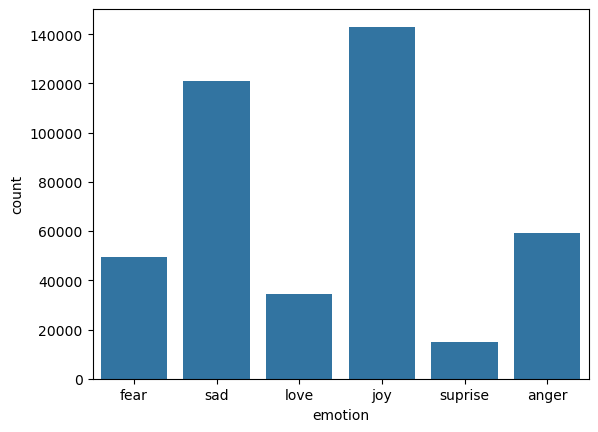

In [5]:
sns.countplot(x='emotion',data=df)

In [6]:
import nltk

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [7]:
!pip install emoji

In [8]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import emoji

# Initialize tools
stop_words = set(stopwords.words("english"))

#  Important: Keep negation words
negation_words = {"not", "no", "nor", "never"}
stop_words = stop_words - negation_words

lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = str(text)
    # 1.Lowercase
    text = text.lower()
    
    # 2.Remove URLs
    text = re.sub(r"http\S+", "", text)
    
    # 3.Remove mentions
    text = re.sub(r"@\w+", "", text)
    
    # 4. Remove hashtags symbol only
    text = re.sub(r"#", "", text)
    
    # 5. Remove special characters & numbers
    text = re.sub(r"[^a-z\s]", "", text)
    
    # 6. Handaling emoji in text
    text = emoji.demojize(text)
    
    # 7. Tokenize
    tokens = word_tokenize(text)
    
    # 8. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # 9. Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # 10. Join words back
    return " ".join(tokens)

In [9]:
df["Clean_Text"] = df["sentence"].apply(clean_text)

In [11]:
print(df[["emotion", "Clean_Text"]].head())

  emotion                                         Clean_Text
0    fear                 feel really helpless heavy hearted
1     sad  ive enjoyed able slouch relax unwind frankly n...
2    fear            gave internship dmrg feeling distraught
3     sad                                dont know feel lost
4    fear  kindergarten teacher thoroughly weary job take...


In [37]:
X = df[['Clean_Text']]
Y = df[['emotion']]

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=42,
    stratify=Y
)

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import FunctionTransformer

In [41]:
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    min_df=2,          # ignore rare words
    max_df=0.9,        # ignore very common words
    sublinear_tf=True  # improves performance
)

In [42]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cv',vectorizer,'Clean_Text'),
    ]
)

In [43]:
pipe_lr = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier',LogisticRegression(C=3.0, class_weight='balanced', max_iter=1000))
])
#pipe_lr.fit(X_train,Y_train)

In [44]:
pipe_lr.fit(X_train,Y_train)

C:\Users\Admin\anaconda3\envs\feel-free-train\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cv', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [45]:
pipe_lr.score(X_test,Y_test)

0.9149024246008279

In [46]:
pipe_svm = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier',LinearSVC())
])
pipe_svm.fit(X_train,Y_train)

C:\Users\Admin\anaconda3\envs\feel-free-train\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cv', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [47]:
pipe_svm.score(X_test,Y_test)

0.9051448846836192

In [48]:
pipe_mul = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier',MultinomialNB())
])
pipe_mul.fit(X_train,Y_train)

C:\Users\Admin\anaconda3\envs\feel-free-train\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cv', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [49]:
pipe_mul.score(X_test,Y_test)

0.8831697220579539

In [50]:
import joblib

joblib.dump(pipe_lr, "emotion_model.pkl")

['emotion_model.pkl']